In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fsmodels import SklMultiExpFrequencyScan

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Base class

In [2]:
class BaseModel(BaseEstimator, RegressorMixin):
    
    
    def __init__(self,
                 filling_pulse = 20*10**-6,
                 n_exps = 1,
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False
                ):
        self.filling_pulse = filling_pulse
        self.n_exps = n_exps
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.stop_val = stop_val
        self.verbose = verbose

        
    def _get_phi(self,
                 frequency_powers,
                 time_constant_power,
                ):
        time_constant = tf.pow(10.0, time_constant_power)
        frequency = tf.pow(10.0, frequency_powers)

        a = time_constant * frequency
        b = self.filling_pulse * frequency

        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        return a * exp0 * (1.0 - exp1 - exp2 + exp3)


    def _get_M(self,
               time_constant_power,
               learning_rate=0.2, 
               n_iters=100, 
               stop_val = 10**-10
              ):
        prev_loss = tf.Variable(np.inf, dtype='float64')
        max_freq_pow = tf.Variable(-time_constant_power, dtype='float64')

        for _ in range(n_iters):
            with tf.GradientTape() as tape:

                current_loss = 0.0 - self._get_phi(max_freq_pow, time_constant_power)

            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break

            dfreq_pow = tape.gradient(current_loss, max_freq_pow)
            max_freq_pow.assign_sub(learning_rate * dfreq_pow)

            prev_loss = current_loss

        return -1 / current_loss
    
    
    def predict(self, X):
        f_powers = tf.Variable(X, dtype='float64')
        return self._get_dlts(X=f_powers).numpy()
    
    
    def _get_dlts(self, X):
        raise NotImplementedError('Implement _get_dlts() in ' + self.__class__.__name__ + '.') 
        
        
    def fit(self, X, y):
        raise NotImplementedError('Implement fit() in ' + self.__class__.__name__ + '.') 
    
    
    def _update_M(self):
        self._M = tf.map_fn(fn = self._get_M, elems=self._exps_params[:, 0])
    
    
    @property
    def exps_params_(self):
        '''exps_params_ = [[timeconstant_power_0, amplitude_0],
                           [timeconstant_power_1, amplitude_1],
                           ... ,
                           [timeconstant_power_n, amplitude_n]]'''
        return self._exps_params.numpy()
    
    @exps_params_.setter
    def exps_params_(self, val):
        value = tf.Variable(val, dtype='float64')
        
        condition = not(len(value.shape) == 2 and 
                        value.shape[0] == self.n_exps and 
                        value.shape[1] == 2)
        
        if condition:
            raise ValueError('The shape of exps_params must be equal [to n_exps, 2], ' + 
                             f'specifically {[self.n_exps, 2]}.')
        self._exps_params = value
        self._update_M()
        
        
    @property
    def fit_results_(self):
        return self._fit_results
    
    
    def _get_fit_result(self, loss=None):
        fit_result = pd.DataFrame(self.get_params(), index=[0])
        fit_result['n_exps'] = self.n_exps
        fit_result['loss'] = loss.numpy()
        
        for i, exp_param in enumerate(self.exps_params_):
            fit_result[f'time_constant_{i}'] = exp_param[0]
            fit_result[f'amplitude_{i}'] = exp_param[1]
            
        try:
            fit_result['p_coef'] = self.p_coef_
        except AttributeError:
            pass
        
        return fit_result.sort_index(axis='columns')
        
    
    def print_all_params(self, iteration_number=None, loss=None):
        if iteration_number is not None:
            print(f'iteration # {iteration_number}')
            
        if loss is not None:
            print(f'loss: {loss}')
            
        print(f'exps_params:\n{self.exps_params_}')
        
        try:
            print(f'p_coef: {self.p_coef_}')
        except AttributeError:
            pass
        
        params = self.get_params()
        for key in params.keys():
            print(f'{key}: {params[key]}')
            
        print('\n')

# Single exponential model class

In [3]:
class SklSingleExpFrequencyScan(BaseModel):
    
    
    def __init__(self,
                 filling_pulse = 20*10**-6,
                 fit_p_coef = True,
                 learning_rate = 0.1,
                 n_iters = 1000,
                 stop_val = None,
                 verbose = False
                ):
        
        super().__init__(filling_pulse = filling_pulse,
                         n_exps = 1,
                         learning_rate = learning_rate,
                         n_iters = n_iters,
                         stop_val = stop_val,
                         verbose = verbose)
        
        self.fit_p_coef = fit_p_coef
        
        
    def _get_dlts(self, X):
        frequency_powers = tf.Variable(X, dtype='float64')
        
        phi = self._get_phi(frequency_powers, self._exps_params[0, 0])
        
        return self._exps_params[0, 1] * tf.pow(self._M * phi, self._p_coef)
    
    
    @property
    def p_coef_(self):
        return self._p_coef.numpy()

    @p_coef_.setter
    def p_coef_(self, val):
        self._p_coef = tf.Variable(val, dtype='float64')
        
        
    def fit(self, X, y):
        
        self.exps_params_ = [[np.random.uniform(low=-3.5, high=-1), 3.5]]
        self.p_coef_ = 1.0
        
        frequency_powers = tf.Variable(X, dtype='float64')
        dlts = tf.Variable(y, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        self._fit_results = pd.DataFrame()
        
        for i in range(self.n_iters):
            with tf.GradientTape() as tape:
                predicted_dlts = self._get_dlts(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))
                
            if self.fit_p_coef:
                d_exps_params, d_p_coef = tape.gradient(current_loss, [self._exps_params, self._p_coef])
            else:
                d_exps_params = tape.gradient(current_loss, self._exps_params)
                
            self._fit_results = pd.concat([self._fit_results, 
                                           self._get_fit_result(loss=current_loss)
                                          ],
                                          ignore_index=True)
            if self.verbose:
                self.print_all_params(iteration_number=i, loss=current_loss)
                
            if self.stop_val is not None:
                if tf.abs(current_loss - prev_loss) < self.stop_val:
                    break
                
            self._exps_params.assign_sub(self.learning_rate * d_exps_params)
            self._update_M()
            
            if self.fit_p_coef:
                self._p_coef.assign_sub(self.learning_rate * d_p_coef)
                
            prev_loss = current_loss
        
        return self

In [4]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6)
fs

SklSingleExpFrequencyScan()

In [5]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'fit_p_coef': True,
 'learning_rate': 0.1,
 'n_iters': 1000,
 'stop_val': None,
 'verbose': False}

In [6]:
X = np.linspace(0, 3.5, 100)

fs.exps_params_ = [[-2.5, 3.5]]
fs.p_coef_ = 0.3

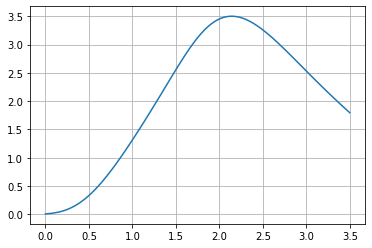

In [7]:
y = fs.predict(X)

plt.plot(X, y)
plt.grid()
plt.show()

In [8]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.05,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = True)

fs.fit(X, y)

iteration # 0
loss: 1.1613516876619392
exps_params:
[[-2.18036385  3.5       ]]
p_coef: 1.0
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 1
loss: 0.8940383699411214
exps_params:
[[-2.27403647  3.51842576]]
p_coef: 0.9249914693514676
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 2
loss: 0.705306175930252
exps_params:
[[-2.33553126  3.53823721]]
p_coef: 0.8482713140609655
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 3
loss: 0.5518958898382766
exps_params:
[[-2.3744694   3.55792061]]
p_coef: 0.770545910307992
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 4
loss: 0.4155449735946274
exps_params:
[[-2.39840637  3.57657564]]
p_coef: 0.69270576614441
fill

iteration # 36
loss: 0.0014425997957930353
exps_params:
[[-2.49393979  3.57400579]]
p_coef: 0.3141902557297077
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 37
loss: 0.0013711916661046392
exps_params:
[[-2.49409799  3.57214544]]
p_coef: 0.31382677345200577
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 38
loss: 0.001303292382084808
exps_params:
[[-2.49424948  3.57033092]]
p_coef: 0.3134735221460597
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 39
loss: 0.0012387310827471152
exps_params:
[[-2.4943951  3.5685612]]
p_coef: 0.31313000877788866
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 40
loss: 0.0011773452688964223
exps_params:
[[-2.4945355   3.5668

p_coef: 0.30562729611120854
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 73
loss: 0.00021822294000362362
exps_params:
[[-2.49758501  3.52871304]]
p_coef: 0.3054845440539975
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 74
loss: 0.000207318208549378
exps_params:
[[-2.49764465  3.52798526]]
p_coef: 0.3053454010880883
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 75
loss: 0.00019695681636002312
exps_params:
[[-2.49770287  3.52727584]]
p_coef: 0.30520977652438236
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 76
loss: 0.0001871118075249613
exps_params:
[[-2.49775969  3.52658434]]
p_coef: 0.3050775819333052
filling_pulse: 1.9999999999999998e-05
fit_p_co

SklSingleExpFrequencyScan(learning_rate=0.05, n_iters=200, stop_val=1e-05,
                          verbose=True)

In [9]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'fit_p_coef': True,
 'learning_rate': 0.05,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': True}

In [10]:
fs.print_all_params()

exps_params:
[[-2.49775969  3.52658434]]
p_coef: 0.3050775819333052
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True




In [11]:
fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_0,verbose
0,3.500000,0.00002,True,0.05,1.161352,1,200,1.000000,0.00001,-2.180364,True
1,3.518426,0.00002,True,0.05,0.894038,1,200,0.924991,0.00001,-2.274036,True
2,3.538237,0.00002,True,0.05,0.705306,1,200,0.848271,0.00001,-2.335531,True
3,3.557921,0.00002,True,0.05,0.551896,1,200,0.770546,0.00001,-2.374469,True
4,3.576576,0.00002,True,0.05,0.415545,1,200,0.692706,0.00001,-2.398406,True
...,...,...,...,...,...,...,...,...,...,...,...
72,3.529460,0.00002,True,0.05,0.000230,1,200,0.305627,0.00001,-2.497524,True
73,3.528713,0.00002,True,0.05,0.000218,1,200,0.305485,0.00001,-2.497585,True
74,3.527985,0.00002,True,0.05,0.000207,1,200,0.305345,0.00001,-2.497645,True
75,3.527276,0.00002,True,0.05,0.000197,1,200,0.305210,0.00001,-2.497703,True


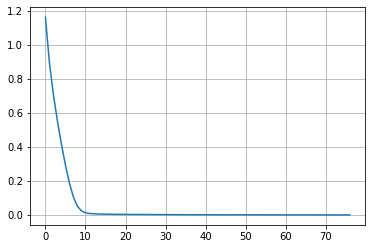

In [12]:
plt.plot(fs.fit_results_.loss)
plt.grid()
plt.show()

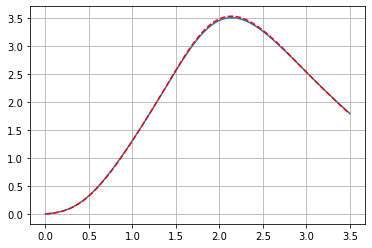

In [13]:
pred_y = fs.predict(X)

plt.plot(X, y)
plt.plot(X, pred_y, '--r')
plt.grid()
plt.show()

In [14]:
mean_squared_error(y, pred_y, squared=False)

0.013678881808282478

In [15]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(fs, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
display_scores(scores)

Scores: [-2.89558787e-05 -1.10656281e-04 -1.08767189e-03 -1.21848248e-03
 -2.06049922e-04]
Mean: -0.0005303632916169507
Standard deviation: 0.0005131945889348844


In [16]:
grid_search = GridSearchCV(fs, {'fit_p_coef': [False, True]}, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [17]:
grid_search.fit(X, y)

iteration # 0
loss: 0.9636103684819973
exps_params:
[[-2.32080909  3.5       ]]
p_coef: 1.0
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 1
loss: 0.8106719479442657
exps_params:
[[-2.36679242  3.52136217]]
p_coef: 0.9266708757696339
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 2
loss: 0.6741264591185776
exps_params:
[[-2.39579544  3.54241341]]
p_coef: 0.8515252010622226
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 3
loss: 0.5434882422741723
exps_params:
[[-2.41341818  3.56259227]]
p_coef: 0.7749976410400977
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 4
loss: 0.4166662382407768
exps_params:
[[-2.42360705  3.58144522]]
p_coef: 0.6979171793105763


exps_params:
[[-2.49373032  3.57684884]]
p_coef: 0.3147341505781021
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 37
loss: 0.0014780923662958195
exps_params:
[[-2.49389222  3.57491768]]
p_coef: 0.314357329242556
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 38
loss: 0.0014049418283902171
exps_params:
[[-2.49404753  3.57303408]]
p_coef: 0.3139910126740089
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 39
loss: 0.001335384237480887
exps_params:
[[-2.49419702  3.571197  ]]
p_coef: 0.31363471237855406
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 40
loss: 0.0012692449652342368
exps_params:
[[-2.49434133  3.56940536]]
p_coef: 0.31328800102494575
filling_

exps_params:
[[-2.49743079  3.53059937]]
p_coef: 0.30584521723832536
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 73
loss: 0.00023540611230101155
exps_params:
[[-2.49749412  3.529824  ]]
p_coef: 0.30569695734039176
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 74
loss: 0.00022364545934350653
exps_params:
[[-2.49755594  3.52906819]]
p_coef: 0.30555244477827836
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 75
loss: 0.00021247059103708533
exps_params:
[[-2.49761628  3.52833145]]
p_coef: 0.3054115854412775
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.05
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 76
loss: 0.00020185246056588654
exps_params:
[[-2.49767517  3.5276133 ]]
p_coef: 0.3052742875601733
f

GridSearchCV(cv=5,
             estimator=SklSingleExpFrequencyScan(learning_rate=0.05,
                                                 n_iters=200, stop_val=1e-05,
                                                 verbose=True),
             n_jobs=-1, param_grid={'fit_p_coef': [False, True]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [18]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.262698085337865 {'fit_p_coef': False}
0.023772663869713294 {'fit_p_coef': True}


# Multi exponential model class